# Daten auslesen

Hier werden die gescrapten Informationen über Leak Sites ausgelesen, damit sie benutzt werden können.

In [2]:
from platform import release

import pandas as pd
from pandas import read_csv, concat, DataFrame
from script.normalizer import normalize

deepdarkcti = read_csv('out/deepdarkcti.csv')
reddit2024 = read_csv('out/reddit2024.csv')
darknet = read_csv('out/darknet.csv')
ransomwatch = read_csv('out/ransomwatch.csv')
ransomfind = read_csv('out/ransomfind.csv')
ransomlook = read_csv('out/ransomlook.csv')
ransomwarelive = read_csv('out/ransomwarelive.csv')
ransomfeed = read_csv('out/ransomfeed.csv')

all_trackers = [deepdarkcti, reddit2024, darknet, ransomwatch, ransomfind, ransomlook, ransomwarelive, ransomfeed]

indexers = {
    'deepdarkcti': deepdarkcti,
    'reddit2024': reddit2024,
    'darknet': darknet,
    'ransomwatch': ransomwatch,
    'ransomfind': ransomfind,
    'ransomlook': ransomlook,
    'ransomwarelive': ransomwarelive,
    'ransomfeed': ransomfeed
}

normalize(all_trackers)

# Aliase ersetzen

Wird eine Gruppe auf verschiedenen Trackern anders benannt, werden sie hier so umbenannt, dass es passt.

In [3]:
from pandas import concat

all_aliases = dict()

def replace_alias(name):
    if name in aliases:
        return replace_alias(all_aliases[name])
    return name

while True:
    aliases = dict()
    all_groups = concat(all_trackers)
    all_groups = all_groups.sort_values(by='Group')
    
    duplicates = dict()
    
    for _, entry in all_groups.iterrows():
        if entry['Link'] not in duplicates:
            duplicates[entry['Link']] = []
        if entry['Group'] not in duplicates[entry['Link']]:
            duplicates[entry['Link']].append(entry['Group'])
    
    for key in duplicates:
        if len(duplicates[key]) <= 1:
            continue
        alias = duplicates[key][0]
        for group in duplicates[key][1:]:
            aliases[group] = alias

    if len(aliases) == 0:
        break
        
    for key in aliases:
        all_aliases[key] = aliases[key]
            
    for tracker in all_trackers:
        tracker['Group'] = tracker['Group'].transform(lambda name: replace_alias(name))

all_groups = concat(all_trackers)
all_groups = all_groups.sort_values(by='Group')

# Gruppen ausgeben

Hier einmal alle Leak Sites, die gefunden wurden:

In [4]:
all_groups

,Group,Link,Available,AvailableLabel
1,0mega,0mega.cc,True,True
257,0mega,omegalock5zxwbhswbisc42o2q2i54vdulyvtqqbudqous...,True,True
1,0mega,0mega.cc,True,True
0,0mega,omegalock5zxwbhswbisc42o2q2i54vdulyvtqqbudqous...,True,True
0,0mega,omegalock5zxwbhswbisc42o2q2i54vdulyvtqqbudqous...,True,True
...,...,...,...,...
141,zeon,zeonrefpbompx6rwdqa5hxgtp2cxgfmoymlli3azoanisz...,False,False
425,zero tolerance,zhuobnfsddn2myfxxdqtpxk367dqnntjf3kq7mrzdgienf...,False,True
371,zero tolerance,zhuobnfsddn2myfxxdqtpxk367dqnntjf3kq7mrzdgienf...,False,False
1341,zero tolerance,zhuobnfsddn2myfxxdqtpxk367dqnntjf3kq7mrzdgienf...,False,False


# Auswertung der Online-Status-Anzeigen

Alle Ressourcen außer der Reddit-Post geben neben dem Link auch an, ob er noch erreichbar ist. Der Aggregator hat trotzdem selbst geprüft, ob das auch stimmte. Hier wird das Ergebnis visualisiert.

Ein "False Positive" bedeutet dabei, dass es als Online gekennzeichnet wurde, durch den Aggregator aber mit 60 Sekunden Timeout NICHT erreicht werden konnte.

Ein "False Negative" gibt an, dass es als Offline gekennzeichnet wurde, der Aggregator es aber erreichen konnte. Das kann allerdings auch bedeuten, dass die Seite z.B. durch das FBI beschlagnahmt wurde und nun nur noch eine Warnung enthält.

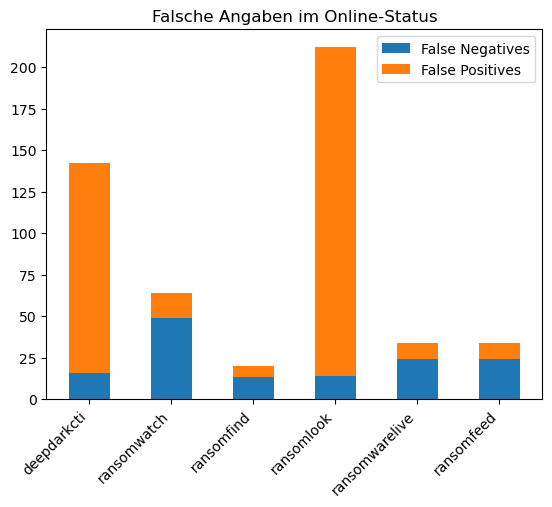

In [38]:
import numpy as np
from matplotlib import pyplot as plt

errors = { 'False Negatives': [], 'False Positives': [] }
indexer_names = []

for indexer in indexers:
    indexer_df = indexers[indexer]
    if 'AvailableLabel' not in indexer_df:
        continue

    false_negative = indexer_df[indexer_df['Available'] == True]
    false_negative = false_negative[false_negative['AvailableLabel'] == False]
    false_positive = indexer_df[indexer_df['Available'] == False]
    false_positive = false_positive[false_positive['AvailableLabel'] == True]

    indexer_names.append(indexer)
    errors['False Negatives'].append(len(false_negative))
    errors['False Positives'].append(len(false_positive))

fig, ax = plt.subplots()
plt.xticks(rotation=45, ha='right')

bottom = np.zeros(len(indexer_names))

for boolean, weight_count in errors.items():
    p = ax.bar(indexer_names, weight_count, 0.5, label=boolean, bottom=bottom)
    bottom += weight_count

ax.legend(loc="upper right")
plt.title('Falsche Angaben im Online-Status')
plt.show()

# Abdeckung der Ressourcen

In den nächsten Zellen wird geprüft, wie viele Leak Sites die einzelnen Ressourcen kennen.

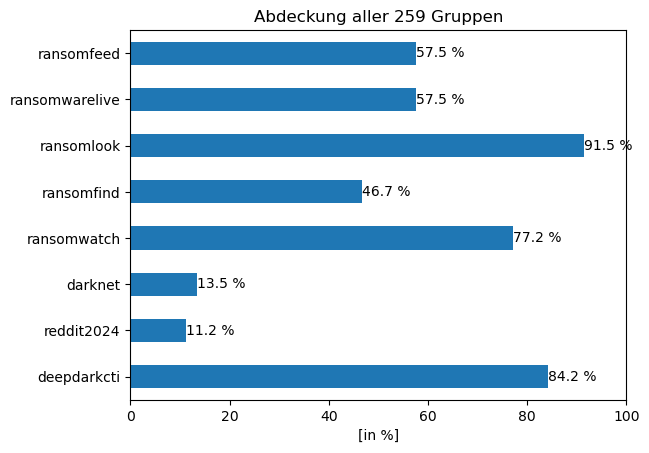

In [24]:
from script.tracked_status import get_tracked_status

tracking_status_all = get_tracked_status(all_groups, False, indexers)

groups_all = tracking_status_all['Group'].count()
relative_all = tracking_status_all.sum(numeric_only=True).transform(lambda x: x * 100 / groups_all)

ax_all = relative_all.plot.barh(xlim=[0, 100])
ax_all.bar_label(ax_all.containers[0], fmt="%.3g %%")
plt.title(f"Abdeckung aller {groups_all} Gruppen")
plt.xlabel(f"[in %]")
plt.show()

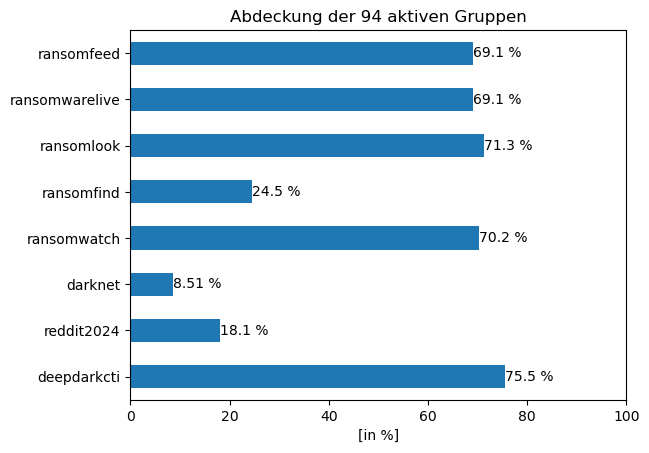

In [23]:
tracking_status_active = get_tracked_status(all_groups, True, indexers)

groups_active = tracking_status_active['Group'].count()
relative_active = tracking_status_active.sum(numeric_only=True).transform(lambda x: x * 100 / groups_active)

ax_all = relative_active.plot.barh(xlim=[0, 100])
ax_all.bar_label(ax_all.containers[0], fmt="%.3g %%")
plt.title(f"Abdeckung der {groups_active} aktiven Gruppen")
plt.xlabel(f"[in %]")
plt.show()

# Einzigartige Leak Sites

Hier wird analysiert, wie viele Leak Sites eine Gruppe von Ressourcen kennt, die nur diese Gruppe kennt.

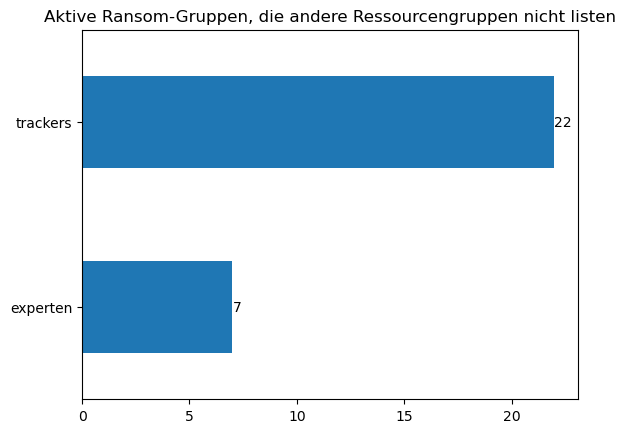

In [37]:
indexer_groups = {
    'experten': concat([darknet, reddit2024, deepdarkcti]),
    'trackers': concat([ransomwatch, ransomfind, ransomfeed, ransomlook])
}

tracking_status_active = get_tracked_status(all_groups, True, indexer_groups)

unique_active = tracking_status_active[(tracking_status_active == True).sum(axis=1) == 1]

unique_active = unique_active.sum(numeric_only=True)

ax_all = unique_active.plot.barh()
ax_all.bar_label(ax_all.containers[0], fmt="%.3g")
plt.title(f"Aktive Ransom-Gruppen, die andere Ressourcengruppen nicht listen")
plt.show()

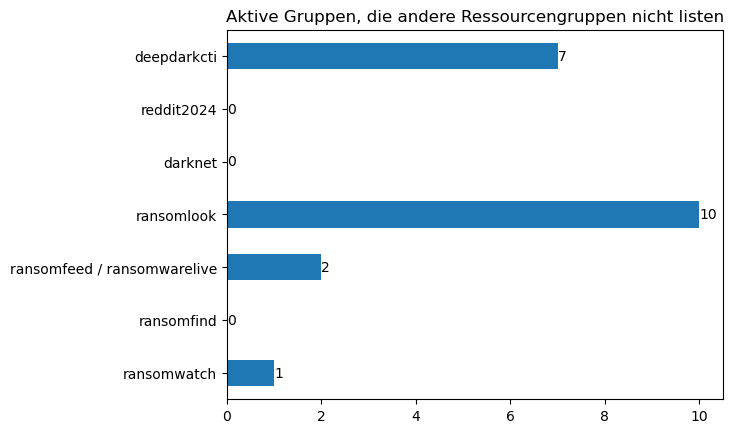

In [22]:
indexer_groups = {
    'ransomwatch': ransomwatch,
    'ransomfind': ransomfind,
    'ransomfeed / ransomwarelive': ransomfeed,
    'ransomlook': ransomlook,
    'darknet': darknet,
    'reddit2024': reddit2024,
    'deepdarkcti': deepdarkcti
}

tracking_status_active = get_tracked_status(all_groups, True, indexer_groups)

unique_active = tracking_status_active[(tracking_status_active == True).sum(axis=1) == 1]

unique_active = unique_active.sum(numeric_only=True)

ax_all = unique_active.plot.barh()
ax_all.bar_label(ax_all.containers[0], fmt="%.3g")
plt.title(f"Aktive Gruppen, die andere Ressourcengruppen nicht listen")
plt.show()

# Abfragen der Posts

Hier werden von der API die bekannten Posts abgefragt, damit wir später damit arbeiten können.

In [25]:
from io import StringIO
from requests import get

import pandas as pd
from datetime import datetime

ransomlook_posts = pd.json_normalize(get('https://www.ransomlook.io/api/recent/100000').json())
ransomwatch_posts = pd.json_normalize(get('https://raw.githubusercontent.com/joshhighet/ransomwatch/main/posts.json').json())

ransomfind_posts_csv = get('https://ransomfind.io/allposts.md').text
ransomfind_posts_csv = ransomfind_posts_csv.splitlines()
while not ransomfind_posts_csv[0].startswith('|'):
    ransomfind_posts_csv.pop(0)
ransomfind_posts_csv.pop(1) # Header-Endzeile entfernen
ransomfind_posts_csv = [line.strip('|') for line in ransomfind_posts_csv] # '|' Am Anfang und Ende der Zeile entfernen
ransomfind_posts = pd.read_csv(StringIO('\n'.join(ransomfind_posts_csv)), sep='|')

ransomwarelive_posts = []
for year in range(2012, datetime.now().year + 1):
    ransomwarelive_posts.append(pd.json_normalize(get(f'https://api.ransomware.live/victims/{year}').json()))
ransomwarelive_posts = pd.concat(ransomwarelive_posts)

# Abfragen der ältesten Posts

Hier wird geschaut, wie weit die Post-Daten zurückgehen.

In [11]:
print(f"Ransomlook: Daten seit {ransomlook_posts['discovered'].min()}")
print(f"Ransomfind: Daten seit {ransomfind_posts[' Date of publication '].min()}")
print(f"Ransomwarelive: Daten seit {ransomwarelive_posts['discovered'].min()}")
print(f"Ransomwatch: Daten seit {ransomwatch_posts['discovered'].min()}")

Ransomlook: Daten seit 2020-01-12 00:00:00.000000
Ransomfind: Daten seit  2020-01-12 
Ransomwarelive: Daten seit 2013-11-06 00:00:00.000000
Ransomwatch: Daten seit 2020-01-12 00:00:00.000000


# Normalisieren & Prüfen der Posts

Hier werden die verschiedenen Quellen normalisiert und jeweils geprüft, ob es ein medizinisches Ziel ist.

In [26]:
from script.normalizer import normalize_group
import re

keywords = [
    "medical",
    "hospital",
    "hospitals",
    "clinic",
    "dentist",
    "dentists",
    "dental",
    "patient",
    "patients",
    "recover",
    "recovery",
    "doctor",
    "doctors",
    "nurse",
    "nurses",
    "nursing",
    "health",
    "healthcare",
    "pediatric",
    "pediatry",
    "rehab",
    "rehabilitation"
]

# ggf. insurance, laboratory

def check_healthcare(*strs):
    found_kws = set()
    for str in strs:
        for token in re.split(r'\W', str.lower()):
            if token in keywords:
                found_kws.add(token)
    return found_kws

posts = { 'Group': [], 'Victim': [], 'Date': [], 'IsHealthcare': [], 'Keywords': [], 'Link': [] }

normalized_ransomwarelive_posts = { 'Group': [], 'Victim': [], 'Date': [], 'IsHealthcare': [], 'Keywords': [], 'Link': [] }
for index, post in ransomwarelive_posts.iterrows():
    posts['Group'].append(replace_alias(normalize_group(post['group_name'])))
    posts['Victim'].append(post['post_title'])
    posts['Date'].append(post['discovered'][:10])

    kws = check_healthcare(post['description'], post['post_title'])
    if post['activity'] == 'Healthcare':
        posts['IsHealthcare'].append(True)
    else:
        posts['IsHealthcare'].append(len(kws) > 0)
    posts['Keywords'].append(kws)
    posts['Link'].append(post['post_url'] or None)

for index, post in ransomwatch_posts.iterrows():
    posts['Group'].append(replace_alias(normalize_group(post['group_name'])))
    posts['Victim'].append(post['post_title'])
    posts['Date'].append(post['discovered'][:10])

    kws = check_healthcare(post['post_title'])
    posts['IsHealthcare'].append(len(kws) > 0)
    posts['Keywords'].append(kws)
    posts['Link'].append(None)

for index, post in ransomlook_posts.iterrows():
    posts['Group'].append(replace_alias(normalize_group(post['group_name'])))
    posts['Victim'].append(post['post_title'])
    posts['Date'].append(post['discovered'][:10])

    kws = check_healthcare(post['post_title'], str(post['description']))
    posts['IsHealthcare'].append(len(kws) > 0)
    posts['Keywords'].append(kws)
    posts['Link'].append(post['link'])

for index, post in ransomfind_posts.iterrows():
    try:
        parsed_title = re.search(r"\[`(.*)`]", post[' Post title '])
        parsed_group = re.search(r"\[([^]]*)]", post[' Ransomware-group '])
    except:
        continue
    posts['Group'].append(replace_alias(normalize_group(parsed_group.group(1))))
    posts['Victim'].append(parsed_title.group(1))
    posts['Date'].append(post[' Date of publication '].strip())

    kws = check_healthcare(parsed_title.group(1))
    posts['IsHealthcare'].append(len(kws) > 0)
    posts['Keywords'].append(kws)
    posts['Link'].append(None)

posts = pd.DataFrame(posts)
posts['IsHealthcare'] = posts['IsHealthcare'].astype('bool')
posts = posts.drop_duplicates(subset=['Group', 'Victim', 'Date'])

# Verteilung

Hier wird geschaut, wie viele Gruppen es jeweils mit welchem Anteil an medizinischen Zielen gibt.

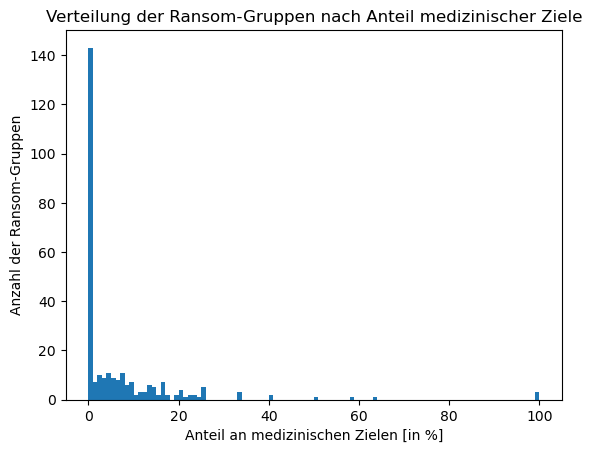

In [31]:
absolut_alle = posts.groupby('Group')['Group'].count()
absolut_healthcare = posts[posts['IsHealthcare']].groupby('Group')['Group'].count()

gruppen = DataFrame({
    'insgesamt': absolut_alle,
    'healthcare': absolut_healthcare
})
gruppen = gruppen.fillna(0)
gruppen['relativ'] = gruppen['healthcare'] / gruppen['insgesamt'] * 100

# gruppen = gruppen[gruppen['insgesamt'] > 50]
gruppen = gruppen.sort_values(by='relativ', ascending=False)

plt.hist(gruppen['relativ'], bins=100)
plt.title('Verteilung der Ransom-Gruppen nach Anteil medizinischer Ziele')
plt.ylabel('Anzahl der Ransom-Gruppen')
plt.xlabel('Anteil an medizinischen Zielen [in %]')
plt.show()

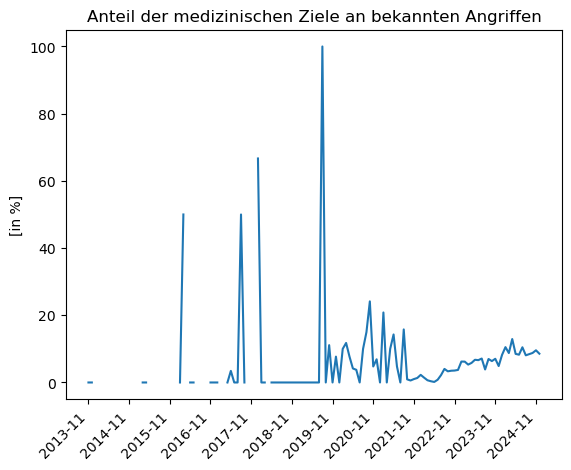

In [36]:
from matplotlib.ticker import MultipleLocator
from pandas import to_datetime, DataFrame
from datetime import datetime

posts['Date'] = to_datetime(posts['Date'])
posts['Month'] = posts['Date'].dt.to_period('M')

data_all = posts['Month'].value_counts()
data_medical = posts[posts['IsHealthcare']]['Month'].value_counts()

all = DataFrame({
    'all': data_all,
    'medical': data_medical,
})
idx = pd.date_range(str(min(all.index)), str(datetime.now())[:10], freq='M').to_period('M')
all = all.reindex(idx)
all = all.fillna(0)

all['part'] = all['medical'] / all['all']
all = all.sort_index(ascending=False)
all.index = all.index.astype('str')

all.part = all.part * 100

fig, ax = plt.subplots()
plt.xticks(rotation=45, ha='right')
ax.plot(sorted(all.index), all.part.sort_index())
ax.xaxis.set_major_locator(MultipleLocator(12))
plt.title("Anteil der medizinischen Ziele an bekannten Angriffen")
plt.ylabel("[in %]")
plt.show()

# Liste mit zuletzt erfolgten Angriffen auf medizinische Ziele

Hier werden nur die Posts angezeigt, bei denen ein Link zur weiteren Analyse vorliegt.

In [15]:
relevant = posts[posts['IsHealthcare']]
relevant = relevant[relevant['Link'].notna()]
relevant = relevant.sort_values(by='Date', ascending=False)
relevant

,Group,Victim,Date,IsHealthcare,Keywords,Link,Month
16496,8base,Carrollton Orthopaedic Clinic,2025-01-03,True,{clinic},http://xfycpauc22t5jsmfjcaz2oydrrrfy75zuk6chr3...,2025-01
16502,8base,Lyons Specialty Co.,2025-01-03,True,{health},http://xfycpauc22t5jsmfjcaz2oydrrrfy75zuk6chr3...,2025-01
31153,8base,Lyons Specialty Co.,2025-01-03,True,{health},http://xfycpauc22t5jsmfjcaz2oydrrrfy75zuk6chr3...,2025-01
31159,8base,Carrollton Orthopaedic Clinic,2025-01-03,True,{clinic},http://xfycpauc22t5jsmfjcaz2oydrrrfy75zuk6chr3...,2025-01
16485,ransomhub,www.metlife.com,2024-12-31,True,{dental},http://ransomxifxwc5eteopdobynonjctkxxvap77yqi...,2024-12
...,...,...,...,...,...,...,...
42760,dispossessor,handrhealthcare.com,2022-12-04,True,"{patient, patients, healthcare, health, nurses}",392,2022-12
42847,dispossessor,www.stginternational.com,2022-11-27,True,"{medical, nurse}",346,2022-11
4208,everest,Stages Pediatric Care New 250 personal records,2022-10-23,True,{pediatric},http://ransomocmou6mnbquqz44ewosbkjk3o5qjsl3or...,2022-10
4209,everest,Stages Pediatric Care New 40 personal records,2022-10-23,True,{pediatric},http://ransomocmou6mnbquqz44ewosbkjk3o5qjsl3or...,2022-10
